# Setting up PySpark in Colab

In [ ]:
# Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, we download Java.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Download Apache Spark. You can find the link to the file at https://spark.apache.org/downloads.html 
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-11-22 02:04:41--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   180MB/s    in 1.6s    

2021-11-22 02:05:01 (180 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [ ]:
# Unzip Apache Spark with Hadoop 3.2
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [ ]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [ ]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
# Install and import the ‘findspark’ library that will locate Spark on the system and import it as a regular library
!pip install -q findspark

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [ ]:
sc

<SparkContext master=local[*] appName=final-project>

# Loading Data

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/CS-GY 6513/Final Project"

'Big Data Project Proposal.pdf'   fire_archive_SV-C2_234861.csv
 DL_FIRE_J1V-C2_234860.zip	  fire_nrt_J1V-C2_234860.csv
 DL_FIRE_M-C61_234859.zip	  fire_nrt_M-C61_234859.csv
 DL_FIRE_SV-C2_234861.zip	  fire_nrt_SV-C2_234861.csv
 fire_archive_M-C61_234859.csv	  Readme.txt


In [ ]:
# Load fire data
rawData = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .format("csv")\
    .load("/content/drive/MyDrive/CS-GY 6513/Final Project/fire_archive_M-C61_234859.csv")

# Exploratory Data Analysis

In [ ]:
rawData.show()
rawData.printSchema()

+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 38.5422| -78.3047|     304.8| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        23|   6.03|     280.9|40.3|       N|   0|
| 38.5586|  -78.317|     302.3| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        45|   6.03|     279.8|36.0|       N|   0|
| 38.5451| -78.3107|     309.9| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        79|   6.03|     280.7|58.8|       N|   0|
| 38.5563| -78.3084|     309.4| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        70|   6.03|     280.4|54.5|       N|   0|
| 31.3393| -89.9124|     304.9| 1.0|  1.0|2000-11-01|     427|    Ter

Data attribute fields: 
https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl#ed-firms-attributes

In [ ]:
# import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
# Add a column acq_year acq_month, acq_hour
hotspotData = rawData\
    .withColumn("year", split(col("acq_date"), "-")[0].cast(IntegerType()))\
    .withColumn("month", split(col("acq_date"), "-")[1].cast(IntegerType()))\
    .withColumn("day", split(col("acq_date"), "-")[2].cast(IntegerType()))\
    .withColumn("acq_time", col("acq_time").cast(StringType()))\
    .withColumn("hour", expr("substring(acq_time, 1, length(acq_time) - 2)").cast(IntegerType()))\
    .select("latitude", "longitude", "brightness", "year", "month","day","hour", "frp", "type")

In [ ]:
hotspotData.show()
hotspotData.printSchema()

+--------+---------+----------+----+-----+---+----+----+----+
|latitude|longitude|brightness|year|month|day|hour| frp|type|
+--------+---------+----------+----+-----+---+----+----+----+
| 38.5422| -78.3047|     304.8|2000|   11|  1|   2|40.3|   0|
| 38.5586|  -78.317|     302.3|2000|   11|  1|   2|36.0|   0|
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|40.9|   0|
| 36.7139| -84.2139|     302.4|2000|   11|  1|   4|32.1|   0|
| 36.7099| -84.2202|     300.9|2000|   11|  1|   4|29.2|   0|
|  41.63

In [ ]:
# According to the descriptions of the attribute fields
# type column has four different values
# 0 = presumed vegetation fire
# 1 = active volcano
# 2 = other static land source
# 3 = offshore detection (includes all detections over water)

# Let's see the distribution of this field
typeCount = hotspotData\
    .groupBy("type")\
    .count()\
    .orderBy("Type")\
    .show()

+----+-------+
|type|  count|
+----+-------+
|   0|2310297|
|   1|  64715|
|   2| 107328|
|   3|   1900|
+----+-------+



In [ ]:
# We will focus on fire data
fireData = hotspotData\
    .where(col("type") == 0)

fireData.show()

+--------+---------+----------+----+-----+---+----+----+----+
|latitude|longitude|brightness|year|month|day|hour| frp|type|
+--------+---------+----------+----+-----+---+----+----+----+
| 38.5422| -78.3047|     304.8|2000|   11|  1|   2|40.3|   0|
| 38.5586|  -78.317|     302.3|2000|   11|  1|   2|36.0|   0|
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|40.9|   0|
| 36.7139| -84.2139|     302.4|2000|   11|  1|   4|32.1|   0|
| 36.7099| -84.2202|     300.9|2000|   11|  1|   4|29.2|   0|
| 38.446

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2000|   11| 2373|
|2000|   12| 1025|
|2001|    1| 1286|
|2001|    2| 1809|
|2001|    3| 2627|
|2001|    4| 4258|
|2001|    5| 2613|
|2001|    6|  718|
|2001|    7| 2546|
|2001|    8| 7151|
|2001|    9| 4472|
|2001|   10| 6641|
|2001|   11| 4516|
|2001|   12| 1312|
|2002|    1| 1151|
|2002|    2| 2597|
|2002|    3| 1889|
|2002|    4| 3477|
|2002|    5| 3848|
|2002|    6| 7828|
+----+-----+-----+
only showing top 20 rows

+----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|year|   1|    2|    3|    4|   5|    6|    7|    8|    9|   10|  11|  12|
+----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|2000|null| null| null| null|null| null| null| null| null| null|2373|1025|
|2001|1286| 1809| 2627| 4258|2613|  718| 2546| 7151| 4472| 6641|4516|1312|
|2002|1151| 2597| 1889| 3477|3848| 7828|13817|16628| 7071| 5738|6169|2661|
|2003|4537| 2988| 7822|12921|3230| 6583|12339|14080|12468|18133|6430

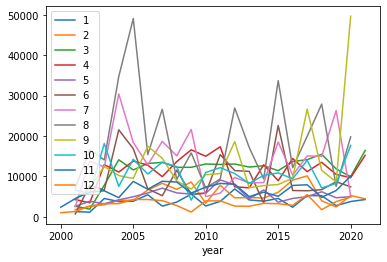

In [ ]:
# Analyze fire frequency change across the US
fireFrequency = fireData\
    .groupBy("year", "month")\
    .count()\
    .orderBy("year", "month")

fireFrequency.show()

# Change of fire frequency by month
frequencyPivot = fireFrequency\
    .groupBy("year")\
    .pivot("month")\
    .sum("count")\
    .orderBy("year")

frequencyPivot.show()

# Visualization of fire frequency change
import pandas as pd
import matplotlib.pyplot as plt

pdDF = fireFrequency.toPandas()
fig, ax = plt.subplots()
for key, grp in pdDF.groupby(['month']):
    ax = grp.plot(ax = ax, 
                  kind = 'line', 
                  x = 'year', 
                  y = 'count', 
                  label = key)

plt.legend(loc='best')
plt.show()

